In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Autosaving every 180 seconds


In [2]:
import importlib
import sys
sys.path.append('../')
import src
importlib.reload(src)

<module 'src' (namespace)>

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import numpy as np
from scipy.io import loadmat, savemat
import src.plot_utils as plot_utils
import src.ml_utils as ml_utils
import src.eikonal as eikonal
import src.openst.OpenST as ost
import timeit
from tqdm import tqdm_notebook

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [4]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.backend import tf
# import tensorflow as tf
from keras.engine.topology import Layer
import keras
from keras.constraints import NonNeg, MinMaxNorm
from IPython.display import clear_output

In [ ]:
model_t, model_eikonal, model_vectorfield = eikonal.init_model(nh=50, layers=3, shape=(1,), activation='relu', 
                                            lr=5e-3, decay=1e-6, init='glorot_normal', 
                                            include_velocity=False, blambda1=10.0, blambda2=1.0, blambda3=1.0, 
                                            monotonity_dxy=True, mlambda1=0.01, mlambda2=.01)

model_eikonal.summary()

In [5]:
def get_homo_model(x, z, v, ixs, izs):
    X, Z = np.meshgrid(x, z)
    R = np.sqrt((X - x[ixs])**2 + (Z - z[izs])**2)
    T = R / v
    B = get_bounds(T, ixs, izs)
    return X, Z, T, B, R

def layered_model(nx, nz, h_inds, v_list):
    V = np.full((nx, nz), v_list[0])
    for hi, vi in zip(h_inds, v_list[1:]):
        V[:, hi:] = vi
    return V

def get_bounds(T, ixs, izs):
    B = np.full_like(T, -1.0)
    B[ixs, izs] = 0.0
    return B

def prepare_inputs(inputs, keywords):
    input_train = {}
    for kw, inp in zip(keywords, inputs):
        input_train[kw] = inp
    return input_train

def vel_func(v0, a):
    def _f(z):
        return v0 + a * z
    return _f

def t_vgrad(X, Z, xs, zs, v0, a):
    vfunc = vel_func(v0, a)
    Zdiff = Z - zs
    Xdiff = X - xs
    Vxszs = vfunc(zs)
    up = a**2 * (Zdiff**2 + Xdiff**2)
    down = 2 * Vxszs * (a * Zdiff + Vxszs)
    tau = np.arccosh(up / down + 1) / a
    return tau

def t_vfield_vgrad(X, Z, xs, zs, v0, a):
    vfunc = vel_func(v0, a)
    Zdiff = Z - zs
    Xdiff = X - xs
    Vxszs = vfunc(zs)
    up = a**2 * (Zdiff**2 + Xdiff**2)
    down = 2 * Vxszs * (a * Zdiff + Vxszs)
    A = 1 / a / np.sqrt((up / down + 1)**2 - 1)
    dt_dx = 2 * a**2 * Xdiff / down * A
    dt_dz = (2 * a**2 * Zdiff / down - 2 * a * Vxszs * up / down**2) * A
    return np.stack([dt_dx, dt_dz], axis=-1)

In [ ]:
############################################
######## HOMOGENEUOS VELOCITY MODEL ########
############################################

N = 50
x = np.linspace(0, 1.0, N)
z = np.linspace(0, 1.0, N)

ixs, izs = 24, 24
sou = np.array([x[ixs], z[izs]])
v = 5.0

X, Z, T, B, R = get_homo_model(x, z, v, ixs, izs)
V = np.full_like(X, v)

X_shift, Z_shift = X - sou[0], Z - sou[1]
V_scaled = V / V.max()
T_scaled = T * V.max()

data_homo = prepare_inputs([X_shift.ravel(), Z_shift.ravel(), V_scaled.ravel(), R.ravel(), B.ravel(), T_scaled], 
                           ['input_x', 'input_y', 'velocity', 'input_r', 'out', 'true'])

In [ ]:
N = 51
x = np.linspace(0, 1000.0, N)
z = np.linspace(0, 1000.0, N)
X, Z = np.meshgrid(x, z, indexing='ij')

ixs, izs = 5, 5
sou = np.array([x[ixs], z[izs]])
V = layered_model(N, N, [25], [1000, 2500])
B = get_bounds(V, ixs, izs)

X_shift, Z_shift = X - sou[0], Z - sou[1]
V_scaled = V / V.max()

data_homo = prepare_inputs([X_shift.ravel(), Z_shift.ravel(), V_scaled.ravel(), B.ravel()], 
                           ['input_x', 'input_y', 'velocity', 'out', 'true'])

## Analytic solution for vertical gradient

In [6]:
nx, nz = 51, 51
xmin, xmax = 0, 1000
zmin, zmax = 0, 1000
frames = np.array([xmin, xmax, zmin, zmax])
scaler = max(abs(frames))

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
X, Z = np.meshgrid(x, z, indexing='ij')

vmin, vmax = 1000.0, 4000.0
a = (vmax - vmin) / z.max()

V = vel_func(vmin, a)(Z)

In [7]:
Tau = np.empty(shape=X.shape + (nx, nz))
for ind, _ in np.ndenumerate(X):
    Tau[ind] = t_vgrad(X, Z, X[ind], Z[ind], vmin, a)

In [8]:
ixs, izs = 25, 25
xs, zs = X[ixs, izs], Z[ixs, izs]
sou = [xs, zs]
V_scaled = V / V.max()
X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / scaler, Z_shift / scaler

R = np.linalg.norm(np.stack([X_scaled, Z_scaled], axis=-1), axis=-1)
B = np.full_like(R, -1.0)
B[R == 0] = 0.0

tau_grad = t_vfield_vgrad(X, Z, xs, zs, vmin, a)

tau = Tau[ixs, izs]
T_scaled = tau * V.max() / scaler


dx = x[1] - x[0]
dz = z[1] - z[0]
grad_x, grad_z = np.gradient(tau, dx, dz)
grad = np.stack([grad_x, grad_z], axis=-1)

diff_grad = np.linalg.norm(grad - tau_grad, axis=-1)

grad /= np.linalg.norm(grad, axis=-1, keepdims=True) + 1e-16

tau_modul = np.linalg.norm(tau_grad, axis=-1, keepdims=True) + 1e-16
tau_grad /= tau_modul

diff_grad = diff_grad / tau_modul.squeeze() * 100

data_inhomo = prepare_inputs([X_scaled.ravel(), Z_scaled.ravel(), V_scaled.ravel(), B.ravel(), tau], 
                             ['input_x', 'input_y', 'velocity', 'out', 'true'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


In [ ]:
step = 3

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_1 = tau_grad[::step, ::step, 0]
V_1 = -tau_grad[::step, ::step, 1]
U_2 = grad[::step, ::step, 0]
V_2 = -grad[::step, ::step, 1]

plt.figure(figsize=(15,10))

extent=(x.min(), x.max(), z.min(), z.max())

plt.subplot(121)
plt.contourf(tau.T, extent=extent)
plt.ylim([z.max(), z.min()])
plt.quiver(X_, Z_, U_1, V_1, scale=25)
# plt.quiver(X_, Z_, U_2, V_2, scale=20)
plt.axis('scaled')

plt.subplot(122)
plt.contourf(diff_grad.T, extent=extent)
plt.ylim([z.max(), z.min()])
plt.colorbar(fraction=1/22)
plt.axis('scaled')
plt.show()

## FSM solution for vertical gradient

In [ ]:
%%time
CoordLimLow = np.array([xmin, zmin])
CoordLimHigh = np.array([xmax, zmax])
GridSize = np.array([nx, nz])
GridStep = (CoordLimHigh - CoordLimLow) / (GridSize - 1)

FSM = np.empty(shape=(nx,nz,nx,nz))
with tqdm_notebook(total=nx*nz, desc='Eikonal solving') as p_bar:
    for ind, _ in np.ndenumerate(X):
        SRC = np.array([X[ind], Z[ind]])
        FSM[ind] = ost.LSM2D(V, CoordLimLow, CoordLimHigh, GridStep, SRC)
        p_bar.update()

In [ ]:
AE = abs(Tau - FSM)
rAE = AE / (Tau + 1e-16) * 100
MAE = AE.mean(axis=(2,3))
rMAE = rAE.mean(axis=(2,3))

plt.figure()
plt.title('{0:.2f} %'.format(rMAE.mean()))
plt.contourf(rMAE.T, extent=(xmin,xmax,zmin,zmax))
plt.ylim([zmax, zmin])
plt.colorbar(fraction=1/22)
plt.axis('scaled')
plt.show()

In [ ]:
mae = abs(tau - FSM[ixs,izs]) / (tau + 1e-16) * 100

fig, axes = plot_utils.plot_images([[tau.T, FSM[ixs,izs].T, mae.T]], cols_names=[['Analytic solution', 'FSM solution', 
                'Residual. MAE {0:.2f} s, {1:.2f} %'.format(mae.mean(), mae.mean())]],
                sources=[[sou, sou, sou]], figsize=(20,15), fontsize=18, imshows=False, extent=(xmin,xmax,zmin,zmax), source_size=10)
plt.show()

In [ ]:
N = 49
plt.figure()
plt.plot(tau.T[:, N], 'k', lw=3)
plt.plot(times[ix,iz].T[:, N], '--b', lw=1.5)
plt.show()

In [ ]:
%%time

input_train = data_inhomo
output_train = data_inhomo['true'].ravel()

input_test = data_inhomo
# output_test = data_inhomo['out']


model_t, model_eikonal, model_vectorfield = eikonal.init_model(nh=50, layers=3, shape=(1,), activation='tanh', 
                                    lr=1e-3, decay=1e-5, init='glorot_normal', 
                                    include_velocity=False, blambda1=1.0, blambda2=0.0, blambda3=0.0, 
                                    monotonity_dxy=False, monotonity_drdxy=False, mlambda1=1.0, mlambda2=0.0)

start, end = 0, 100
epochs = 200
M = model_eikonal
for i in range(start, end):
    clear_output(wait=True)

    T_true_train = input_train['true']
    T_pred_train = model_t.predict(input_train).reshape((nx, nz)) / V.max() * scaler

    MAE_train = T_pred_train - T_true_train
    print('Train errors: {0:.4f} s, {1:.2f} %'.format(MAE_train.std(), MAE_train.std() / T_true_train.mean() * 100))
   
    fig, axes = plot_utils.plot_images(imgs=[[T_true_train.T, T_pred_train.T, MAE_train.T]], 
                            cols_names=[['True solution', 'Epochs = {}\nANN solution'.format(i*epochs), 'Residual']], 
                            sources=[[sou]], extent=(x.min(),x.max(),z.min(),z.max()), source_size=10, figsize = (18, 12), fontsize=20, 
                            imshows=False)

    plt.show()

    history = M.fit(
        input_train, 
        output_train, 
        batch_size=len(output_train),
        epochs=epochs,
        shuffle=True,
        validation_split=.0,
        verbose=0
    )

In [ ]:
N = 50
plt.figure()
plt.plot(tau[:, N], 'k', lw=3)
plt.plot(T_pred_train[:, N], '--b', lw=1.5)
plt.show()

In [9]:
def expansion_batches(arrays, names, center, step_i, step_j, start):
  
    shape = arrays[0].shape
    assert len(arrays) == len(names), 'Number of arrays must be equal to number of their names'
    assert len(shape) == 2, '2D arrays must have only two axes'
    for k in range(1, len(arrays)):
        assert arrays[k].shape == shape, 'All arrays must have the same shape'

  
    to_up = center[0]
    to_left = center[1]
    to_down = shape[0] - center[0] - 1
    to_right = shape[1] - center[1] - 1

    max_ = max([int(to_up / step_i), int(to_down / step_i), 
              int(to_left / step_j), int(to_right / step_j)])
    max_ += 1

    indices = []
    batches = np.empty((max_ - start,), dtype=dict)
    for m in range(start, max_):
        add_i = m * step_i
        add_j = m * step_j

        up = center[0] - add_i
        up *= up >= 0
        left = center[1] - add_j
        left *= left >= 0
        down = center[0] + add_i + 1
        down -= (down > shape[0]) * (down - shape[0])
        right = center[1] + add_j + 1
        right -= (right > shape[1]) * (right - shape[1])

        up_down = np.arange(up, down, 1)
        left_right = np.arange(left, right, 1)
        inds = np.stack(np.meshgrid(up_down, left_right, indexing='ij'), axis=-1).reshape(-1, 2)
        inds = [(x[0],x[1]) for x in inds]
        indices.append(inds)
        input_k = {}
        for k, name in enumerate(names):
            input_k[name] = arrays[k][up : down, left : right].ravel()
        batches[m - start] = input_k
    return batches, indices

def expansion_fronts(arrays, names, center, step_i, step_j):
    shape = arrays[0].shape
    assert len(arrays) == len(names), 'Number of arrays must be equal to number of their names'
    assert len(shape) == 2, '2D arrays must have only two axes'
    for k in range(1, len(arrays)):
        assert arrays[k].shape == shape, 'All arrays must have the same shape'

  
    to_up = center[0]
    to_left = center[1]
    to_down = shape[0] - center[0] - 1
    to_right = shape[1] - center[1] - 1

    max_ = max([int(to_up / step_i), int(to_down / step_i), 
              int(to_left / step_j), int(to_right / step_j)])
    max_ += 1

    indices = []
    batches = np.empty((max_-1,), dtype=dict)
    
    for m in range(1, max_):
        add_i = m * step_i
        add_j = m * step_j

        up = center[0] - add_i
        up *= up >= 0
        left = center[1] - add_j
        left *= left >= 0
        down = center[0] + add_i
        down -= (down > shape[0]) * (down - shape[0])
        right = center[1] + add_j
        right -= (right > shape[1]) * (right - shape[1])
        
        up_down = np.arange(up + 1, down, 1)
        left_right = np.arange(left, right + 1, 1)
        line1 = np.stack([up_down, np.full_like(up_down, left)], axis=-1)
        line2 = np.stack([up_down, np.full_like(up_down, right)], axis=-1)
        line3 = np.stack([np.full_like(left_right, up), left_right], axis=-1)
        line4 = np.stack([np.full_like(left_right, down), left_right], axis=-1)
        inds = np.concatenate([line1, line2, line3, line4], axis=0)
        inds = [(x[0],x[1]) for x in inds]
        inds.append(center)
        indices.append(inds)
        input_k = {}
        for k, name in enumerate(names):
            arr = []
            for ind in inds:
                arr.append(arrays[k][ind])
            input_k[name] = np.array(arr)
        batches[m-1] = input_k
    return batches, indices

In [10]:
data, indices = expansion_batches(arrays=[X_scaled, Z_scaled, V_scaled, B], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds'],
                                  center=(ixs, izs), step_i=1, step_j=1, start=1)

# data, indices = expansion_fronts(arrays=[X_scaled, Z_scaled, V_scaled, B], 
#                                   names=['input_x', 'input_y', 'velocity', 'bounds'],
#                                   center=(ixs, izs), step_i=1, step_j=1)

## CNN model to train

In [46]:
m1, m2, m3 = eikonal.cnn_model(filters=10, layers=3, kernel_sizes=(5,5), shape=(51,51,1))
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            (None, 51, 51, 1)    0                                            
__________________________________________________________________________________________________
input_y (InputLayer)            (None, 51, 51, 1)    0                                            
__________________________________________________________________________________________________
concatenate_19 (Concatenate)    (None, 51, 51, 2)    0           input_x[0][0]                    
                                                                 input_y[0][0]                    
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 47, 47, 10)   510         concatenate_19[0][0]             
__________

In [44]:
data_inhomo = prepare_inputs([X_scaled[None, ..., None], Z_scaled[None, ..., None], V_scaled[None, ..., None], B[None, ..., None]], 
                             ['input_x', 'input_y', 'velocity', 'bounds'])

1
MAE = 109.855 ms, 91.22 %


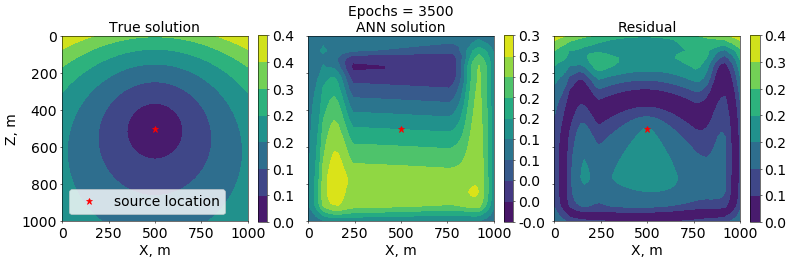

KeyboardInterrupt: 

In [48]:
%%time

T_true = tau
input_train = data_inhomo
output_train = data_inhomo['bounds']
    
epochs = 100
M = m2
for i in range(0, 100):

    M.fit(
        input_train, 
        output_train, 
        batch_size=1,
        epochs=epochs,
        shuffle=True,
        validation_split=.0,
        verbose=0,
#         callbacks=[plot_losses]
    )

    clear_output(wait=True)
    T_pred = m1.predict(input_train) / V.max() * scaler
    T_pred_2d = T_pred.reshape(T_true.shape)
#     print(batch_size)
    MAE = abs(T_pred_2d - T_true)
    MAE[ixs, izs] = 0
    rMAE = MAE / (T_true + 1e-16) * 100
    print('MAE = {0:.3f} ms, {1:.2f} %'.format(MAE.mean() * 1000, rMAE.mean()))
    fig, axes = plot_utils.plot_images(imgs=[[T_true.T, T_pred_2d.T, MAE.T]], 
                            cols_names=[['True solution', 'Epochs = {}\nANN solution'.format(epochs*(i+1)), 'Residual']], 
                            sources=[[sou, sou, sou]], extent=(xmin,xmax,zmin,zmax), source_size=10, figsize = (18, 12),  
                            fontsize=20, imshows=False, colorbars=True)

    plt.show()

## FCNN model

In [ ]:
model_t, model_eikonal, model_vectorfield = eikonal.init_model(
                                    nh=100, layers=2, shape=(1,), activation='tanh', 
                                    lr=3e-3, decay=1e-4, init='glorot_normal', 
                                    include_velocity=False, blambda1=1.0, blambda2=0.0, blambda3=0.0, 
                                    monotonity_dxy=True, monotonity_drdxy=False, mlambda1=1.0, mlambda2=0.0)
model_eikonal.summary()

In [ ]:
%%time
input_test = data_inhomo
T_true = tau

epochs = np.linspace(2500, 100, len(data), dtype=int)
# epochs = 10
M = model_eikonal
k = 1
for i in range(0, len(data)):
    input_train = data[k*i]
    output_train = data[k*i]['bounds']
    batch_size = len(output_train)


    M.fit(
        input_train, 
        output_train, 
        batch_size=batch_size,
        epochs=epochs[k*i],
        shuffle=True,
        validation_split=.0,
        verbose=0,
#         callbacks=[plot_losses]
    )

    clear_output(wait=True)
    T_pred = model_t.predict(input_test) / V.max() * scaler
    T_pred_2d = T_pred.reshape(T_true.shape)
    print(batch_size)
    MAE = abs(T_pred_2d - T_true)
    MAE[ixs, izs] = 0
    rMAE = MAE / (T_true + 1e-16) * 100
    print('MAE = {0:.3f} ms, {1:.2f} %'.format(MAE.mean() * 1000, rMAE.mean()))
    fig, axes = plot_utils.plot_images(imgs=[[T_true.T, T_pred_2d.T, MAE.T]], 
                            cols_names=[['True solution', 'Epochs = {}\nANN solution'.format(epochs[k*i]), 'Residual']], 
                            sources=[[sou, sou, sou]], extent=(xmin,xmax,zmin,zmax), source_size=10, figsize = (18, 12),  
                            fontsize=20, imshows=False, colorbars=True)

    plt.show()

In [ ]:
# model_t.save('../nn_models/model_t')
# model_eikonal.save('../nn_models/model_eikonal')
# model_vectorfield.save('../nn_models/model_vectorfield')

In [ ]:
tau_grad = t_vfield_vgrad(X, Z, xs, zs, vmin, a)
tau_modul = np.linalg.norm(tau_grad, axis=-1, keepdims=True) + 1e-16
tau_grad_norm = tau_grad / tau_modul

pred_grad = model_vectorfield.predict(input_test) / V.max()
pred_grad = pred_grad.reshape(T_pred_2d.shape + (2,))
pred_modul = np.linalg.norm(pred_grad, axis=-1, keepdims=True) + 1e-16
pred_grad_norm = pred_grad / pred_modul

diff_grad = np.linalg.norm(tau_grad - pred_grad, axis=-1)
r_diff_grad = diff_grad / tau_modul.squeeze() * 100

step = 2

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_1 = tau_grad_norm[::step, ::step, 0]
V_1 = -tau_grad_norm[::step, ::step, 1]

U_2 = pred_grad_norm[::step, ::step, 0]
V_2 = -pred_grad_norm[::step, ::step, 1]

In [ ]:
MAE = abs(T_pred_2d - tau)
rMAE = MAE / (tau + 1e-16) * 100
rMAE[ixs, izs] = MAE[ixs, izs]

In [ ]:
imgs = [[V.T / 1000, tau.T, T_pred_2d.T]]
quiver = [[None, [X_, Z_, U_1, V_1], [X_, Z_, U_2, V_2]]]
sources = [[sou, sou, sou, sou, sou]]
cols_names = [['Velocity model', 'Analytical solution', 'Neural network solution', 'Relative absolute error of traveltimes', 'Relative error of gradient']]
imshows = [[True, False, False, True, True]]
colorbars = True
cbar_labels = [['velocity, km/s', 'traveltime, sec', 'traveltime, sec', 'traveltime error, %', 'gradient error, %']]
figsize = (35, 20)
fontsize = 25

fig, axes = plot_utils.plot_images(imgs=imgs, cols_names=cols_names, quiver=quiver, imshows=imshows, colorbars=colorbars, cbar_labels=cbar_labels,
                        sources=sources, extent=(xmin,xmax,zmin,zmax), source_size=15, figsize=figsize, fontsize=fontsize,)

plt.show()

In [ ]:
imgs = [[rMAE.T, r_diff_grad.T]]
quiver = None
sources = np.array(sou)
cols_names = [['Relative absolute error of traveltimes', 'Relative error of gradient']]
imshows = True
colorbars = True
cbar_labels = [['traveltime error, %', 'gradient error, %']]
figsize = (22, 15)
fontsize = 25
extent=(xmin,xmax,zmin,zmax)

fig, axes = plot_utils.plot_images(imgs=imgs, cols_names=cols_names, quiver=quiver, imshows=imshows, colorbars=colorbars, cbar_labels=cbar_labels,
                        sources=sources, extent=extent, source_size=15, figsize=figsize, fontsize=fontsize,legend=False)

plt.show()

In [ ]:
extent = (x.min(), x.max(), z.min(), z.max())

mae = abs(tau - T_pred_2d) / tau * 100
mae[ixs, izs] = 0
# mae2 = abs(tau - result[1]) / (tau + 1e-16) * 100

fsm = FSM[ixs,izs]
fsm_mae = abs(tau - fsm) / (tau + 1e-16) * 100

imgs = [[tau.T * 1000, fsm.T * 1000, fsm_mae.T], 
        [tau.T * 1000, T_pred_2d.T * 1000, mae.T]]

cols_names = [['Аналитическое решение', 'Решение FSM', 'Относительна ошибка, mae {0:.2f} %'.format(fsm_mae.mean())], 
              ['Аналитическое решение', 'Решение нейронной сети', 'Относительна ошибка, mae {0:.2f} %'.format(mae.mean())]]

imshows = False
colorbars = [[True, True, True], 
             [True, True, True], 
             [True, True, True]]
cbar_labels = [['время, мс', 'время, мс', 'ошибка, %'], 
               ['время, мс', 'время, мс', 'ошибка, %']]

sources = [[sou, sou, sou],[sou, sou, sou]]
source_label = 'положение источника'

fig, axes = plot_utils.plot_images(imgs=imgs, cols_names=cols_names, imshows=imshows, colorbars=colorbars, cbar_labels=cbar_labels,
                        figsize=(25,14), extent=extent, sources=sources, source_label=source_label,
                        source_size=12)

plt.show()

In [ ]:
N = 13
plt.figure(figsize=(12,6))
plt.plot(T_true[:,N], '-*r', label='True')
plt.plot(T_pred_2d[:,N])
plt.legend(loc='best')
plt.show()

## Marmousi test

In [49]:
from scipy.ndimage import gaussian_filter as gauss

In [50]:
V = np.float32(np.load('../data/Marmousi_Pwave_1.25m.npy', ))

In [51]:
V_smooth = gauss(V, 100)

In [9]:
dx, dz = 1.25, 1.25
step = 50
V_sm_sp = V_smooth[::step,::step]
dx, dz = dx*step, dz*step

NameError: name 'V_smooth' is not defined

In [54]:
np.save('../data/Marmousi_Pwave_smooth_{}m.npy'.format(dx), V_sm_sp)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.imshow(V.T)
ax2.imshow(V_sm_sp.T)
plt.show()

In [55]:
del V, V_smooth

In [5]:
V_sm_sp = np.load("../data/Marmousi_Pwave_smooth_62.5m.npy")

In [11]:
xmin, xmax = 0, dx * V_sm_sp.shape[0]
zmin, zmax = 0, dz * V_sm_sp.shape[1]

x = np.arange(xmin, xmax, dx)
z = np.arange(zmin, zmax, dz)
X, Z = np.meshgrid(x, z, indexing='ij')

CoordLimLow = np.array([xmin, zmin], dtype=np.float64)
CoordLimHigh = np.array([xmax, zmax], dtype=np.float64)

GridStep = np.array([dx, dz])
ixs, izs = int(len(x) / 2), int(len(z) / 3)
xs, zs = x[ixs], z[izs]
src = np.array([xs, zs])

T = ost.LSM2D(V_sm_sp, CoordLimLow, CoordLimHigh, GridStep, src)

NameError: name 'V_sm_sp' is not defined

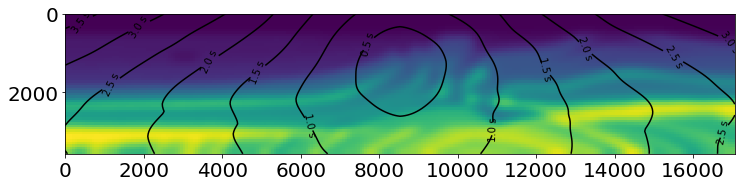

In [57]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
img = ax.imshow(V_sm_sp.T, extent=[xmin,xmax,zmax,zmin])
cs = ax.contour(T.T, colors='k', extent=(xmin,xmax,zmin,zmax))
# plt.colorbar(mappable=img, ax=ax, fraction=1/22)
ax.clabel(cs, cs.levels, inline=True, inline_spacing=5, fmt='%r s', fontsize=10)
plt.show()

In [93]:
xz_scaler = abs(np.array([xmin,xmax,zmin,zmax])).max()
X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / xz_scaler, Z_shift / xz_scaler
v_scaler = V_sm_sp.max()
V_scaled = V_sm_sp / v_scaler
B = get_bounds(X_shift, ixs, izs)

input_test = prepare_inputs([X_scaled.ravel(), Z_scaled.ravel(), V_scaled.ravel()], 
                            ['input_x', 'input_y', 'velocity'])
# input_test = prepare_inputs([X_shift.ravel(), Z_shift.ravel(), V_scaled.ravel()], 
#                             ['input_x', 'input_y', 'velocity'])

In [96]:
data, indices = expansion_batches(arrays=[X_scaled, Z_scaled, V_scaled, B], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds'],
                                  center=(ixs, izs), step_i=6, step_j=2, start=1)

# data, indices = expansion_batches(arrays=[X_shift, Z_shift, V_scaled, B], 
#                                   names=['input_x', 'input_y', 'velocity', 'bounds'],
#                                   center=(ixs, izs), step_i=6, step_j=2, start=1)

In [99]:
model_t, model_eikonal, model_vectorfield = eikonal.init_model(
                                    nh=50, layers=3, shape=(1,), activation='relu', 
                                    lr=1e-3, decay=1e-4, init='glorot_normal',
                                    include_velocity=False, blambda1=1.0, blambda2=0.5, blambda3=0.5, 
                                    monotonity_dxy=True, monotonity_drdxy=False, mlambda1=0.5, mlambda2=0.0)
model_eikonal.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_y (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 2)            0           input_x[0][0]                    
                                                                 input_y[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 50)           150         concatenate_23[0][0]             
__________

14421 / 15105
MAE = 585.525 ms, 33.99 %


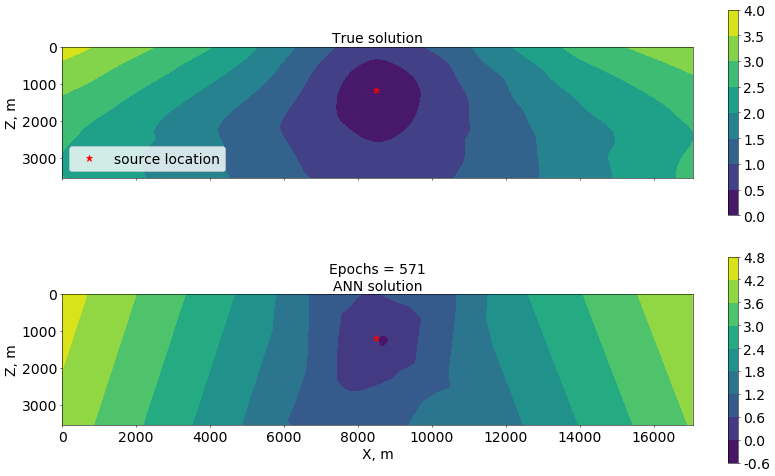

Wall time: 11min 27s


In [100]:
%%time

T_true = T

epochs = np.linspace(2000, 500, len(data), dtype=int)
# epochs = 10
M = model_eikonal
k = 1
for i in range(0, len(data)):
    input_train = data[k*i]
    output_train = data[k*i]['bounds']
    batch_size = len(output_train)


    M.fit(
        input_train, 
        output_train, 
        batch_size=batch_size,
        epochs=epochs[k*i],
        shuffle=True,
        validation_split=.0,
        verbose=0,
#         callbacks=[plot_losses]
    )
    
    if i % 2 == 0:
        clear_output(wait=True)
        T_pred = model_t.predict(input_test) / v_scaler * xz_scaler
        T_pred_2d = T_pred.reshape(T_true.shape)
        print(batch_size, '/', len(data[-1]['bounds']))
        MAE = abs(T_pred_2d - T_true)
        rMAE = MAE / (T_true + 1e-16) * 100
        rMAE[ixs, izs] = 100
        print('MAE = {0:.3f} ms, {1:.2f} %'.format(MAE.mean() * 1000, rMAE.mean()))
        fig, axes = plot_utils.plot_images(imgs=[[T_true.T], [T_pred_2d.T]], 
                                cols_names=[['True solution'], ['Epochs = {}\nANN solution'.format(epochs[k*i])]], 
                                sources=[[src], [src]], extent=(xmin,xmax,zmin,zmax), source_size=10, figsize = (18, 12),  
                                fontsize=20, imshows=False, colorbars=True)

        plt.show()

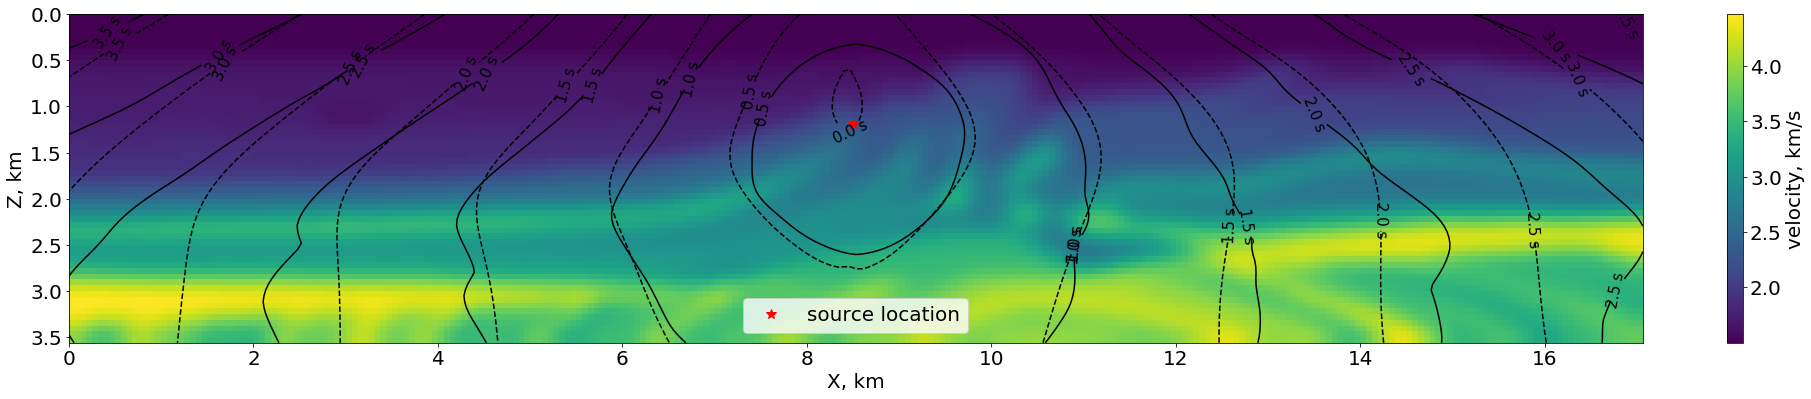

In [91]:
x0,xn,z0,zn = np.array([xmin,xmax,zmin,zmax]) / 1000

fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111)

img = ax.imshow(V_sm_sp.T / 1000, extent=(x0,xn,zn,z0))

cs = ax.contour(T.T, colors='k', extent=(x0,xn,z0,zn))
ax.clabel(cs, cs.levels, inline=True, inline_spacing=15, fmt='%r s', fontsize=15)

cs = ax.contour(T_pred_2d.T, colors='k', linestyles='dashed', extent=(x0,xn,z0,zn))
ax.clabel(cs, cs.levels, inline=True, inline_spacing=15, fmt='%r s', fontsize=15)

ax.plot(src[0] / 1000, src[1] / 1000, 'r*', ms=10, label='source location')
plt.colorbar(mappable=img, ax=ax, fraction=1/102, label='velocity, km/s')

ax.set_xlabel('X, km')
ax.set_ylabel('Z, km')
plt.legend(loc='lower center')

plt.show()

In [ ]:
def update_images(axes, imgs, indices, extent, source=None, imshow=False):
    images = []

    for i in range(len(imgs)):
        if imshow:
            upd = axes[indices[i]].imshow(imgs[i], extent=extent)
        else:
            upd = axes[indices[i]].contourf(imgs[i], extent=extent)
            axes[indices[i]].set_ylim([imgs[i].shape[1]-1, 0])
            axes[indices[i]].axis('scaled')

    if source is not None:
        if i + j == 0:
            axes[indices[i]].plot(source[0], source[1], 'r*', ms=source_size, label='source location')
            upd = axes[indices[i]].legend(loc='lower left', fontsize=fontsize)
        else:
            upd = axes[indices[i]].plot(source[0], source[1], 'r*', ms=source_size)
    images.append(upd)

    return images

In [ ]:
imags = []

indices = [(0,1), (0,2)]
for i in range(0, end):
    imag = np.concatenate((pred_u[:, i], mae[:, i]), axis=0)
    print(imag.shape)
    ims = update_images(axes, imgs=imag, indices=indices, extent=(0,2000,0,2000))
    imags.append(ims)

anim = anm.ArtistAnimation(fig, imags, interval=150, blit=True, repeat = True)

anim.save('eikonal_vgrad.gif', dpi=50, writer='imagemagick')

In [ ]:
def discretization(X, nearest_up=1, nearest_down=1, 
                   nearest_left=1, nearest_right=1,
                   step_i=1, step_j=1):
    assert len(X.shape) == 2

    n_cols = X.shape[1] - nearest_left - nearest_right
    n_rows = X.shape[0] - nearest_up - nearest_down

    N = n_cols * n_rows
    N_iter = np.array(np.arange(0, N, 1)).reshape((n_rows, n_cols))
    N_iter = N_iter[::step_i, ::step_j]
    N_iter = np.ravel(N_iter)

    batch_cols = nearest_left + nearest_right + 1
    batch_rows = nearest_up + nearest_down + 1
    batch_size = batch_cols * batch_rows

    batches = np.zeros((N, batch_rows, batch_cols))

    center_indices = []
    scheme_indices = []
    for k, Nk in enumerate(N_iter):

        i = int(Nk // n_cols)
        j = int(Nk % n_cols)

        ik = i + nearest_up
        jk = j + nearest_left
      
        inds_k = []
        for l in range(batch_size):

            il = int(l // batch_cols)
            jl = int(l % batch_cols)

            batches[k, il, jl] = X[il + i, jl + j]
            inds_k.append((il + i, jl + j))

        center_indices.append((ik, jk))
        scheme_indices.append(inds_k)

    return batches, center_indices, scheme_indices

def discretization_crest(X, nearest_up=1, nearest_down=1, 
                         nearest_left=1, nearest_right=1,
                         step_i=1, step_j=1):
    assert len(X.shape) == 2

    n_cols = X.shape[1] - nearest_left - nearest_right
    n_rows = X.shape[0] - nearest_up - nearest_down

    N = n_cols * n_rows
    N_iter = np.array(np.arange(0, N, 1)).reshape((n_rows, n_cols))
    N_iter = N_iter[::step_i, ::step_j]
    N_iter = np.ravel(N_iter)

    batch_cols = nearest_left + nearest_right + 1
    batch_rows = nearest_up + nearest_down
    batch_size = batch_cols + batch_rows

    batches = np.zeros((N, batch_size)) #

    center_indices = []
    scheme_indices = []
    for k, Nk in enumerate(N_iter):

        i = int(Nk // n_cols)
        j = int(Nk % n_cols)

        ik = i + nearest_up
        jk = j + nearest_left
      
        inds_k = []
        for l in range(nearest_left + nearest_right + 1):

            jl = jk + l - nearest_left
            batches[k, l] = X[ik, jl]
            inds_k.append((ik, jl))

        mi = 0
        for m in range(nearest_down + nearest_up + 1):
        
            im = ik + m - nearest_up
            if im != ik:
                batches[k, batch_cols + mi] = X[im, jk]
                inds_k.append((im, jk))
                mi += 1

        center_indices.append((ik, jk))
        scheme_indices.append(inds_k)

    return batches, center_indices, scheme_indices

In [ ]:
batches, c_indexes, s_indexes = discretization_crest(X.squeeze(), 
                                                     nearest_up=1, nearest_down=1, 
                                                     nearest_left=2, nearest_right=2,
                                                     step_i=5, step_j=6)

In [ ]:
arr_s_indexes = np.array(s_indexes)
arr_c_indexes = np.array(c_indexes)

print(batches[0])

print([X.squeeze()[ind] for ind in s_indexes[0]])

In [ ]:
M = np.arange(0, 48)
plt.figure(figsize=(10,10))
plt.imshow(V.squeeze())
for m in M:
    plt.scatter(arr_s_indexes[m,:,1], arr_s_indexes[m,:,0], marker='o', s=10)
    plt.scatter(arr_c_indexes[m,1], arr_c_indexes[m,0], marker='*', c='k', s=25)
plt.show()

In [ ]:
x = np.linspace(-4, 5, 51)
y = np.linspace(-3, 6, 51)
X, Y = np.meshgrid(x, y, indexing = 'ij')

batches, indices = expansion_batches(arrays=[X, Y], names=['X', 'Y'], center=(4,3), step_i=1, step_j=1)


In [ ]:
arr_indices = np.array(indices)

In [ ]:
arr_indices[5][:][0]

In [ ]:
M = 46
plt.figure(figsize=(6,6))
plt.imshow(np.ones((51, 51)))
for arr in arr_indices[M]:
    plt.plot(arr[0], arr[1], '.k')
plt.plot(25, 25, '*r', ms=12)
plt.show()